# 최근접 이웃(K-Nearest Neighbor)

* 데이터 포인트 간의 거리를 기준으로 가장 가까운 k개의 이웃을 찾아 분류 또는 회귀를 수행하는 비모수적(non-parametric) 알고리즘
* 매우 직관적이며, 새로운 데이터 포인트의 클래스나 값을 예측하기 위해 가장 가까운 이웃 데이터를 사용

## k 값의 선택
- **작은 k 값**: 모델이 복잡해지고 과적합(overfitting)될 수 있음
- **큰 k 값**: 모델이 단순해지며 과소적합(underfitting)될 위험이 있음
- 일반적으로 적절한 k 값을 찾기 위해 교차 검증(cross-validation)을 사용

![k nearest neighbor](https://upload.wikimedia.org/wikipedia/commons/thumb/e/e7/KnnClassification.svg/220px-KnnClassification.svg.png)


In [1]:
import pandas as pd
import numpy as np
import multiprocessing
import matplotlib.pyplot as plt
plt.style.use(['seaborn-v0_8-whitegrid'])

In [2]:
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.manifold import TSNE
from sklearn.datasets import load_iris, load_breast_cancer, fetch_california_housing, fetch_california_housing, load_wine
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline

## K 최근접 이웃 분류

* 입력 데이터 포인트와 가장 가까운 k개의 훈련 데이터 포인트가 출력
* k개의 데이터 포인트 중 가장 많은 클래스가 예측 결과

### 붓꽃 데이터

In [3]:
iris = load_iris()

In [4]:
iris_df = pd.DataFrame(data=iris.data, columns=iris.feature_names)
iris_df['Target'] = iris.target
iris_df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),Target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


In [5]:
X, y = load_iris(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [6]:
scaler = StandardScaler()
X_train_scale = scaler.fit_transform(X_train)
X_test_scale = scaler.transform(X_test)

In [7]:
model = KNeighborsClassifier()
model.fit(X_train, y_train)

KNeighborsClassifier()

In [8]:
print('학습 데이터 점수: {}'.format(model.score(X_train, y_train)))
print('평가 데이터 점수: {}'.format(model.score(X_test, y_test)))

학습 데이터 점수: 0.9916666666666667
평가 데이터 점수: 0.9333333333333333


In [9]:
model = KNeighborsClassifier()
model.fit(X_train_scale, y_train)

KNeighborsClassifier()

In [10]:
print('학습 데이터(scaled) 점수: {}'.format(model.score(X_train_scale, y_train)))
print('평가 데이터(scaled) 점수: {}'.format(model.score(X_test_scale, y_test)))

학습 데이터(scaled) 점수: 0.9833333333333333
평가 데이터(scaled) 점수: 0.9


In [11]:
cross_validate(
    estimator = KNeighborsClassifier(),
    X=X, y=y,
    cv=5,
    n_jobs=multiprocessing.cpu_count(),
    verbose=True
)

[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   5 out of   5 | elapsed:    0.6s finished


{'fit_time': array([0.0006299 , 0.00062227, 0.00068021, 0.00063014, 0.00082302]),
 'score_time': array([0.00183797, 0.00217319, 0.00203109, 0.00183821, 0.00234175]),
 'test_score': array([0.96666667, 1.        , 0.93333333, 0.96666667, 1.        ])}

In [12]:
param_grid = [{'n_neighbors':[3, 5, 7],
               'weights': ['uniform', 'distance'],
               'algorithm': ['ball_tree', 'kd_tree', 'brute']}]

In [13]:
gs = GridSearchCV(
    estimator=KNeighborsClassifier(),
    param_grid = param_grid,
    n_jobs=multiprocessing.cpu_count(),
    verbose=True
)

In [14]:
gs.fit(X,y)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


/usr/local/lib/python3.9/site-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(estimator=KNeighborsClassifier(), n_jobs=16,
             param_grid=[{'algorithm': ['ball_tree', 'kd_tree', 'brute'],
                          'n_neighbors': [3, 5, 7],
                          'weights': ['uniform', 'distance']}],
             verbose=True)

In [15]:
gs.best_estimator_

KNeighborsClassifier(algorithm='ball_tree', n_neighbors=7)

In [16]:
print('GridSearchCV_best score: {}'.format(gs.best_score_))

GridSearchCV_best score: 0.9800000000000001


In [17]:
def make_meshgrid(x, y, h=0.02):
    x_min, x_max = x.min()-1, x.max()+1
    y_min, y_max = y.min()-1, y.max()+1
    xx, yy, = np.meshgrid(np.arange(x_min, x_max, h),
                          np.arange(y_min, y_max, h))
    
    return(xx, yy)

def plot_contours(clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = plt.contourf(xx, yy, Z, **params)
    
    return out

In [18]:
tsne = TSNE(n_components=2)
X_comp = tsne.fit_transform(X)

In [19]:
iris_comp_df = pd.DataFrame(data=X_comp)
iris_comp_df['Target'] = y
iris_comp_df

,0,1,Target
0,-24.284670,-0.196069,0
1,-21.731905,0.653882,0
2,-21.776773,-0.433848,0
3,-21.413086,-0.141203,0
4,-24.284908,-0.606254,0
...,...,...,...
145,14.369648,-2.493189,2
146,11.872075,-0.541414,2
147,13.772250,-1.774297,2
148,14.138768,-3.394210,2


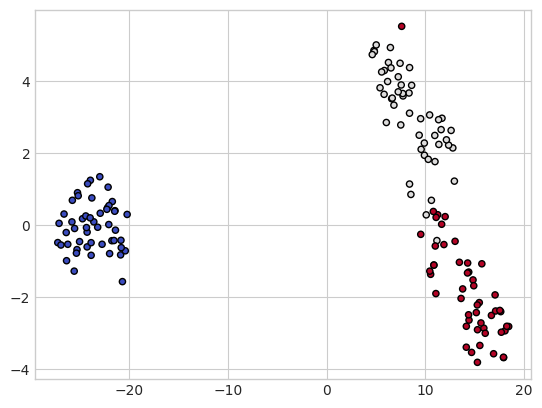

In [20]:
plt.scatter(X_comp[:, 0], X_comp[:, 1],
            c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')

In [21]:
model = KNeighborsClassifier()
model.fit(X_comp, y)
predict = model.predict(X_comp)

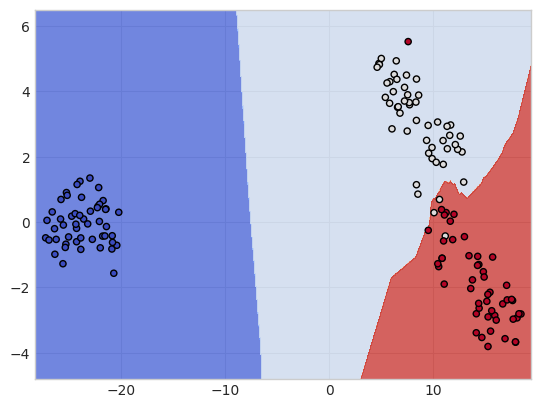

In [22]:
xx, yy = make_meshgrid(X_comp[:, 0], X_comp[:, 1])
plot_contours(model, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
plt.scatter(X_comp[:, 0], X_comp[:, 1], c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k');

### 유방암 데이터

In [23]:
cancer = load_breast_cancer()

In [24]:
cancer_df = pd.DataFrame(data=cancer.data, columns=cancer.feature_names)
cancer_df['target'] = cancer.target
cancer_df

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,0
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,0
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,0
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,0


In [25]:
X, y = cancer.data, cancer.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [26]:
cancer_train_df = pd.DataFrame(data=X_train, columns=cancer.feature_names)
cancer_train_df['target'] = y_train
cancer_train_df

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,20.47,20.67,134.70,1299.0,0.09156,0.13130,0.15230,0.10150,0.2166,0.05419,...,27.15,152.00,1645.0,0.10970,0.2534,0.3092,0.16130,0.3220,0.06386,0
1,18.81,19.98,120.90,1102.0,0.08923,0.05884,0.08020,0.05843,0.1550,0.04996,...,24.30,129.00,1236.0,0.12430,0.1160,0.2210,0.12940,0.2567,0.05737,0
2,14.86,16.94,94.89,673.7,0.08924,0.07074,0.03346,0.02877,0.1573,0.05703,...,20.54,102.30,777.5,0.12180,0.1550,0.1220,0.07971,0.2525,0.06827,1
3,21.16,23.04,137.20,1404.0,0.09428,0.10220,0.10970,0.08632,0.1769,0.05278,...,35.59,188.00,2615.0,0.14010,0.2600,0.3155,0.20090,0.2822,0.07526,0
4,15.05,19.07,97.26,701.9,0.09215,0.08597,0.07486,0.04335,0.1561,0.05915,...,28.06,113.80,967.0,0.12460,0.2101,0.2866,0.11200,0.2282,0.06954,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
450,18.08,21.84,117.40,1024.0,0.07371,0.08642,0.11030,0.05778,0.1770,0.05340,...,24.70,129.10,1228.0,0.08822,0.1963,0.2535,0.09181,0.2369,0.06558,0
451,14.69,13.98,98.22,656.1,0.10310,0.18360,0.14500,0.06300,0.2086,0.07406,...,18.34,114.10,809.2,0.13120,0.3635,0.3219,0.11080,0.2827,0.09208,1
452,17.46,39.28,113.40,920.6,0.09812,0.12980,0.14170,0.08811,0.1809,0.05966,...,44.87,141.20,1408.0,0.13650,0.3735,0.3241,0.20660,0.2853,0.08496,0
453,12.47,18.60,81.09,481.9,0.09965,0.10580,0.08005,0.03821,0.1925,0.06373,...,24.64,96.05,677.9,0.14260,0.2378,0.2671,0.10150,0.3014,0.08750,1


In [27]:
cancer_test_df = pd.DataFrame(data=X_test, columns=cancer.feature_names)
cancer_test_df['target'] = y_test
cancer_test_df

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,9.755,28.20,61.68,290.9,0.07984,0.04626,0.015410,0.01043,0.1621,0.05952,...,36.92,68.03,349.9,0.11100,0.11090,0.07190,0.04866,0.2321,0.07211,1
1,9.567,15.91,60.21,279.6,0.08464,0.04087,0.016520,0.01667,0.1551,0.06403,...,19.16,65.74,335.9,0.15040,0.09515,0.07161,0.07222,0.2757,0.08178,1
2,13.900,16.62,88.97,599.4,0.06828,0.05319,0.022240,0.01339,0.1813,0.05536,...,21.80,101.20,718.9,0.09384,0.20060,0.13840,0.06222,0.2679,0.07698,1
3,17.750,28.03,117.30,981.6,0.09997,0.13140,0.169800,0.08293,0.1713,0.05916,...,38.54,145.40,1437.0,0.14010,0.37620,0.63990,0.19700,0.2972,0.09075,0
4,11.640,18.33,75.17,412.5,0.11420,0.10170,0.070700,0.03485,0.1801,0.06520,...,29.26,85.51,521.7,0.16880,0.26600,0.28730,0.12180,0.2806,0.09097,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109,10.160,19.59,64.73,311.7,0.10030,0.07504,0.005025,0.01116,0.1791,0.06331,...,22.88,67.88,347.3,0.12650,0.12000,0.01005,0.02232,0.2262,0.06742,1
110,14.590,22.68,96.39,657.1,0.08473,0.13300,0.102900,0.03736,0.1454,0.06147,...,27.27,105.90,733.5,0.10260,0.31710,0.36620,0.11050,0.2258,0.08004,1
111,10.260,14.71,66.20,321.6,0.09882,0.09159,0.035810,0.02037,0.1633,0.07005,...,19.48,70.89,357.1,0.13600,0.16360,0.07162,0.04074,0.2434,0.08488,1
112,11.200,29.37,70.67,386.0,0.07449,0.03558,0.000000,0.00000,0.1060,0.05502,...,38.30,75.19,439.6,0.09267,0.05494,0.00000,0.00000,0.1566,0.05905,1


In [28]:
scaler = StandardScaler()
X_train_scale = scaler.fit_transform(X_train)
X_test_scale = scaler.transform(X_test)

In [29]:
model = KNeighborsClassifier()
model.fit(X_train, y_train)

KNeighborsClassifier()

In [30]:
print('학습 데이터 점수: {}'.format(model.score(X_train, y_train)))
print('평가 데이터 점수: {}'.format(model.score(X_test, y_test)))

학습 데이터 점수: 0.945054945054945
평가 데이터 점수: 0.9298245614035088


In [31]:
model = KNeighborsClassifier()
model.fit(X_train, y_train)

KNeighborsClassifier()

In [32]:
print('학습 데이터 점수: {}'.format(model.score(X_train, y_train)))
print('평가 데이터 점수: {}'.format(model.score(X_test, y_test)))

학습 데이터 점수: 0.945054945054945
평가 데이터 점수: 0.9298245614035088


In [33]:
estimator = make_pipeline(
    StandardScaler(),
    KNeighborsClassifier()
)

In [34]:
cross_validate(
    estimator = estimator,
    X=X, y=y,
    cv=5,
    n_jobs=multiprocessing.cpu_count(),
    verbose=True
)

[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   5 out of   5 | elapsed:    0.0s finished


{'fit_time': array([0.00116372, 0.00109768, 0.0011313 , 0.00106025, 0.00110149]),
 'score_time': array([0.00099897, 0.00097799, 0.00101209, 0.00104213, 0.0009613 ]),
 'test_score': array([0.96491228, 0.95614035, 0.98245614, 0.95614035, 0.96460177])}

In [35]:
pipe = Pipeline(
    [('scaler', StandardScaler()),
     ('model', KNeighborsClassifier())]
)

In [36]:
param_grid = [{'model__n_neighbors': [3, 5, 7],
               'model__weights': ['uniform', 'distance'],
               'model__algorithm': ['ball_tree', 'kd_tree', 'brute' ]}]

In [37]:
gs = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    n_jobs=multiprocessing.cpu_count(),
    verbose=True
)

In [38]:
gs.fit(X,y)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model', KNeighborsClassifier())]),
             n_jobs=16,
             param_grid=[{'model__algorithm': ['ball_tree', 'kd_tree', 'brute'],
                          'model__n_neighbors': [3, 5, 7],
                          'model__weights': ['uniform', 'distance']}],
             verbose=True)

In [39]:
gs.best_estimator_

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 KNeighborsClassifier(algorithm='ball_tree', n_neighbors=7))])

In [40]:
print('GridSearchCV best score: {}'.format(gs.best_score_))

GridSearchCV best score: 0.9701288619779538


In [41]:
tsne = TSNE(n_components=2)
X_comp = tsne.fit_transform(X)

In [42]:
cancer_comp_df = pd.DataFrame(data=X_comp)
cancer_comp_df['target'] = y
cancer_comp_df

,0,1,target
0,42.337463,-12.640097,0
1,42.500240,-9.928030,0
2,37.894382,-10.039126,0
3,-17.654438,1.451124,0
4,36.764866,-7.930646,0
...,...,...,...
564,44.029003,-9.311248,0
565,38.830563,-9.435006,0
566,22.498896,-2.705058,0
567,40.378845,-10.038561,0


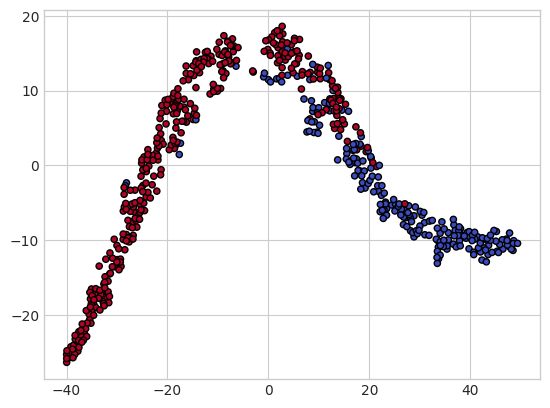

In [43]:
plt.scatter(X_comp[:, 0], X_comp[:, 1], c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k');

In [44]:
model = KNeighborsClassifier()
model.fit(X_comp, y)
predict = model.predict(X_comp)

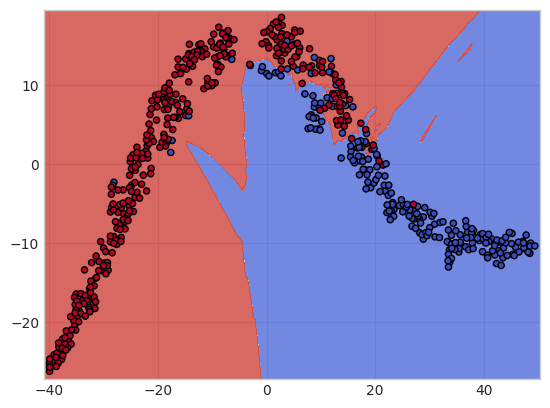

In [45]:
xx, yy = make_meshgrid(X_comp[:, 0], X_comp[:, 1])
plot_contours(model, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
plt.scatter(X_comp[:, 0], X_comp[:, 1], c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k');

### 와인 데이터

In [46]:
wine = load_wine()

In [47]:
wine_df = pd.DataFrame(data=wine.data, columns=wine.feature_names)
wine_df['target'] = wine.target
wine_df

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,13.71,5.65,2.45,20.5,95.0,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740.0,2
174,13.40,3.91,2.48,23.0,102.0,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750.0,2
175,13.27,4.28,2.26,20.0,120.0,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835.0,2
176,13.17,2.59,2.37,20.0,120.0,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840.0,2


In [48]:
X, y = wine.data, wine.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [49]:
wine_train_df = pd.DataFrame(data=X_train, columns=wine.feature_names)
wine_train_df['target'] = y_train
wine_train_df

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,11.84,2.89,2.23,18.0,112.0,1.72,1.32,0.43,0.95,2.65,0.96,2.52,500.0,1
1,13.40,3.91,2.48,23.0,102.0,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750.0,2
2,14.20,1.76,2.45,15.2,112.0,3.27,3.39,0.34,1.97,6.75,1.05,2.85,1450.0,0
3,14.83,1.64,2.17,14.0,97.0,2.80,2.98,0.29,1.98,5.20,1.08,2.85,1045.0,0
4,13.58,2.58,2.69,24.5,105.0,1.55,0.84,0.39,1.54,8.66,0.74,1.80,750.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137,12.82,3.37,2.30,19.5,88.0,1.48,0.66,0.40,0.97,10.26,0.72,1.75,685.0,2
138,13.39,1.77,2.62,16.1,93.0,2.85,2.94,0.34,1.45,4.80,0.92,3.22,1195.0,0
139,13.52,3.17,2.72,23.5,97.0,1.55,0.52,0.50,0.55,4.35,0.89,2.06,520.0,2
140,11.79,2.13,2.78,28.5,92.0,2.13,2.24,0.58,1.76,3.00,0.97,2.44,466.0,1


In [50]:
wine_test_df = pd.DataFrame(data=X_test, columns=wine.feature_names)
wine_test_df['target'] = y_test
wine_test_df

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,12.08,2.08,1.70,17.5,97.0,2.23,2.17,0.26,1.40,3.30,1.27,2.96,710.0,1
1,14.22,3.99,2.51,13.2,128.0,3.00,3.04,0.20,2.08,5.10,0.89,3.53,760.0,0
2,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0
3,13.05,1.73,2.04,12.4,92.0,2.72,3.27,0.17,2.91,7.20,1.12,2.91,1150.0,0
4,12.58,1.29,2.10,20.0,103.0,1.48,0.58,0.53,1.40,7.60,0.58,1.55,640.0,2
5,12.84,2.96,2.61,24.0,101.0,2.32,0.60,0.53,0.81,4.92,0.89,2.15,590.0,2
6,12.00,1.51,2.42,22.0,86.0,1.45,1.25,0.50,1.63,3.60,1.05,2.65,450.0,1
7,13.75,1.73,2.41,16.0,89.0,2.60,2.76,0.29,1.81,5.60,1.15,2.90,1320.0,0
8,13.17,5.19,2.32,22.0,93.0,1.74,0.63,0.61,1.55,7.90,0.60,1.48,725.0,2
9,11.56,2.05,3.23,28.5,119.0,3.18,5.08,0.47,1.87,6.00,0.93,3.69,465.0,1


In [51]:
scaler = StandardScaler()
X_train_scale = scaler.fit_transform(X_train)
X_test_scale = scaler.transform(X_test)

In [52]:
model = KNeighborsClassifier()
model.fit(X_train, y_train)

KNeighborsClassifier()

In [53]:
print('학습 데이터 점수: {}'.format(model.score(X_train, y_train)))
print('평가 데이터 점수: {}'.format(model.score(X_test, y_test)))

학습 데이터 점수: 0.7816901408450704
평가 데이터 점수: 0.7777777777777778


In [54]:
model = KNeighborsClassifier()
model.fit(X_train_scale, y_train)

KNeighborsClassifier()

In [55]:
print('학습 데이터 점수: {}'.format(model.score(X_train_scale, y_train)))
print('평가 데이터 점수: {}'.format(model.score(X_test_scale, y_test)))

학습 데이터 점수: 0.971830985915493
평가 데이터 점수: 0.9722222222222222


In [56]:
estimator = make_pipeline(
    StandardScaler(),
    KNeighborsClassifier()
)

In [57]:
cross_validate(
    estimator = estimator,
    X=X, y=y,
    cv=5,
    n_jobs=multiprocessing.cpu_count(),
    verbose=True
)

[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   5 out of   5 | elapsed:    0.0s finished


{'fit_time': array([0.00122976, 0.00140953, 0.00103712, 0.00100589, 0.00157452]),
 'score_time': array([0.00222397, 0.00367999, 0.00207734, 0.00190234, 0.00346231]),
 'test_score': array([0.94444444, 0.94444444, 0.97222222, 1.        , 0.88571429])}

In [58]:
pipe = Pipeline(
    [('scaler', StandardScaler()),
     ('model', KNeighborsClassifier())]
)

In [59]:
param_grid = [{'model__n_neighbors': [3, 5, 7],
               'model__weights': ['uniform', 'distance'],
               'model__algorithm': ['ball_tree', 'kd_tree', 'brute' ]}]

In [60]:
gs = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    n_jobs=multiprocessing.cpu_count(),
    verbose=True
)

In [61]:
gs.fit(X,y)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model', KNeighborsClassifier())]),
             n_jobs=16,
             param_grid=[{'model__algorithm': ['ball_tree', 'kd_tree', 'brute'],
                          'model__n_neighbors': [3, 5, 7],
                          'model__weights': ['uniform', 'distance']}],
             verbose=True)

In [62]:
gs.best_estimator_

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 KNeighborsClassifier(algorithm='ball_tree', n_neighbors=7))])

In [63]:
print('GridSearchCV best score: {}'.format(gs.best_score_))

GridSearchCV best score: 0.9665079365079364


In [64]:
tsne = TSNE(n_components=2)
X_comp = tsne.fit_transform(X)

In [65]:
cancer_comp_df = pd.DataFrame(data=X_comp)
cancer_comp_df['target'] = y
cancer_comp_df

,0,1,target
0,11.885133,-0.480538,0
1,11.506394,-1.147849,0
2,14.050035,-1.015527,0
3,16.863930,-1.384284,0
4,3.268320,-0.451542,0
...,...,...,...
173,3.289910,-0.019914,2
174,3.707676,-0.103938,2
175,6.272249,-0.490825,2
176,6.423851,-0.620846,2


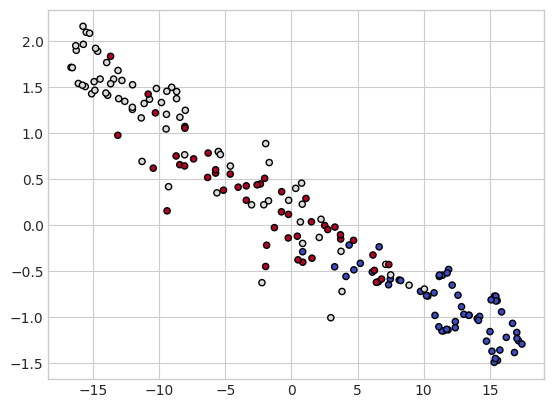

In [66]:
plt.scatter(X_comp[:, 0], X_comp[:, 1], c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k');

In [67]:
model = KNeighborsClassifier()
model.fit(X_comp, y)
predict = model.predict(X_comp)

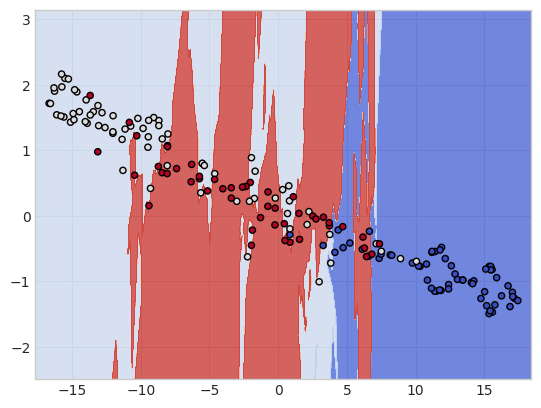

In [68]:
xx, yy = make_meshgrid(X_comp[:, 0], X_comp[:, 1])
plot_contours(model, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
plt.scatter(X_comp[:, 0], X_comp[:, 1], c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k');

## k 최근접 이웃 회귀

* k 최근접 이웃 분류와 마찬가지로 예측에 이웃 데이터 포인트 사용
* 이웃 데이터 포인트의 평균이 예측 결과

### 보스턴 주택 가격 데이터

In [69]:
boston = fetch_california_housing()

In [70]:
boston_df = pd.DataFrame(data=boston.data, columns=boston.feature_names)
boston_df['TARGET'] = boston.target
boston_df

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,TARGET
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
...,...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847


In [71]:
X, y = boston.data, boston.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [72]:
boston_train_df = pd.DataFrame(data=X_train, columns=boston.feature_names)
boston_train_df['TARGET'] = y_train
boston_train_df

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,TARGET
0,5.2149,18.0,4.758427,1.039326,733.0,4.117978,34.20,-118.59,2.019
1,2.5938,40.0,3.811475,1.057377,1203.0,4.930328,33.94,-118.22,1.154
2,3.8906,15.0,4.832386,0.982955,723.0,2.053977,38.67,-121.27,1.287
3,6.1872,19.0,7.415686,1.043137,678.0,2.658824,38.66,-121.27,1.887
4,3.8846,40.0,5.647887,0.992958,1054.0,2.474178,38.40,-122.82,2.159
...,...,...,...,...,...,...,...,...,...
16507,3.5208,48.0,6.203557,1.160079,1319.0,2.606719,33.97,-118.29,1.342
16508,1.9000,16.0,4.975133,1.090586,1695.0,3.010657,40.56,-122.35,0.816
16509,2.2321,46.0,4.927273,1.345455,150.0,2.727273,34.15,-118.09,2.375
16510,1.3713,23.0,4.329939,1.030550,2091.0,4.258656,36.96,-120.04,0.518


In [73]:
boston_test_df = pd.DataFrame(data=X_test, columns=boston.feature_names)
boston_test_df['TARGET'] = y_test
boston_test_df

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,TARGET
0,2.3669,50.0,3.994891,1.053640,2535.0,3.237548,34.29,-119.30,1.653
1,2.5382,33.0,4.670951,1.133676,1220.0,3.136247,37.96,-122.34,1.036
2,4.6793,27.0,5.757576,0.949495,1089.0,3.666667,32.62,-117.04,1.519
3,2.3657,19.0,5.405797,1.041408,1185.0,2.453416,40.09,-122.08,0.940
4,3.7949,13.0,5.832258,1.072581,2189.0,3.530645,34.17,-117.33,1.063
...,...,...,...,...,...,...,...,...,...
4123,5.2835,33.0,5.928058,0.965827,1345.0,2.419065,32.75,-117.02,2.171
4124,2.3487,38.0,4.267647,0.926471,786.0,2.311765,38.53,-121.48,1.016
4125,3.1250,23.0,6.375796,1.242038,369.0,2.350318,38.51,-120.80,0.964
4126,2.8649,17.0,4.223301,1.080097,1158.0,2.810680,33.89,-117.97,1.375


In [74]:
scaler = StandardScaler()
X_train_scale = scaler.fit_transform(X_train)
X_test_scale = scaler.transform(X_test)

In [75]:
model = KNeighborsRegressor()
model.fit(X_train, y_train)

KNeighborsRegressor()

In [76]:
print('학습 데이터 점수: {}'.format(model.score(X_train, y_train)))
print('평가 데이터 점수: {}'.format(model.score(X_test, y_test)))

학습 데이터 점수: 0.4509124363276521
평가 데이터 점수: 0.1483281099222068


In [77]:
model = KNeighborsRegressor()
model.fit(X_train_scale, y_train)

KNeighborsRegressor()

In [78]:
print('학습 데이터 점수: {}'.format(model.score(X_train_scale, y_train)))
print('평가 데이터 점수: {}'.format(model.score(X_test_scale, y_test)))

학습 데이터 점수: 0.7877226137200095
평가 데이터 점수: 0.6995953530196388


In [79]:
estimator = make_pipeline(
    StandardScaler(),
    KNeighborsRegressor()
)

In [80]:
cross_validate(
    estimator=estimator,
    X=X, y=y,
    cv=5,
    n_jobs=multiprocessing.cpu_count(),
    verbose=True
)

[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   5 out of   5 | elapsed:    0.2s finished


{'fit_time': array([0.0140276 , 0.01324439, 0.01308894, 0.01271439, 0.01264572]),
 'score_time': array([0.16848803, 0.13964486, 0.1488924 , 0.1882019 , 0.17159891]),
 'test_score': array([0.47879396, 0.4760079 , 0.57624554, 0.50259828, 0.57228584])}

In [81]:
pipe = Pipeline(
    [('scaler', StandardScaler()),
     ('model', KNeighborsRegressor())]
)

In [82]:
param_grid = [{'model__n_neighbors': [3, 5, 7],
               'model__weights': ['uniform', 'distance'],
               'model__algorithm': ['ball_tree', 'kd_tree', 'brute']}]

In [83]:
gs = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    n_jobs=multiprocessing.cpu_count(),
    verbose=True
)

In [84]:
gs.fit(X, y)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model', KNeighborsRegressor())]),
             n_jobs=16,
             param_grid=[{'model__algorithm': ['ball_tree', 'kd_tree', 'brute'],
                          'model__n_neighbors': [3, 5, 7],
                          'model__weights': ['uniform', 'distance']}],
             verbose=True)

In [85]:
gs.best_estimator_

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 KNeighborsRegressor(algorithm='ball_tree', n_neighbors=7,
                                     weights='distance'))])

In [86]:
print('GridSearchCV best score: {}'.format(gs.best_score_))

GridSearchCV best score: 0.5376515274379832


In [87]:
tsne = TSNE(n_components=1)
X_comp = tsne.fit_transform(X)

In [88]:
boston_comp_df = pd.DataFrame(data=X_comp)
boston_comp_df['TARGET'] = y
boston_comp_df

,0,TARGET
0,-116.769104,4.526
1,89.227425,3.585
2,-98.721977,3.521
3,-90.616730,3.413
4,-89.922958,3.422
...,...,...
20635,-46.852879,0.781
20636,-113.767998,0.771
20637,-23.147985,0.923
20638,-61.939793,0.847


/tmp/ipykernel_17280/1638329518.py:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_comp, y, c='b', cmap=plt.cm.coolwarm, s=20, edgecolors='k');


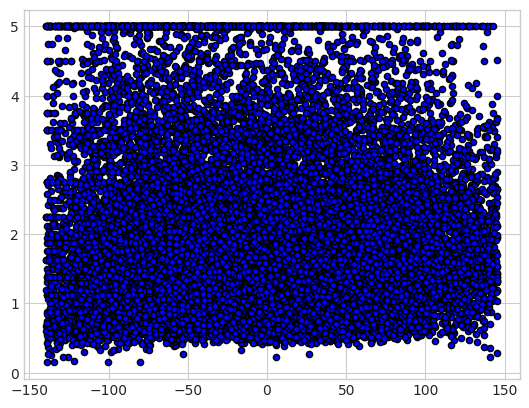

In [89]:
plt.scatter(X_comp, y, c='b', cmap=plt.cm.coolwarm, s=20, edgecolors='k');

In [90]:
model = KNeighborsRegressor()
model.fit(X_comp, y)
predict = model.predict(X_comp)

/tmp/ipykernel_17280/151620241.py:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_comp, y, c='b', cmap=plt.cm.coolwarm, s=20, edgecolors='k');
/tmp/ipykernel_17280/151620241.py:2: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_comp, predict, c='r', cmap=plt.cm.coolwarm, s=20, edgecolors='k');


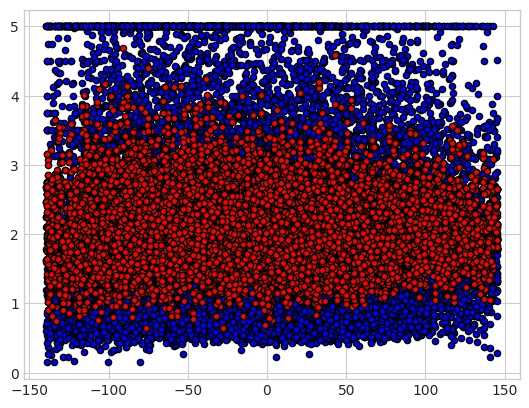

In [91]:
plt.scatter(X_comp, y, c='b', cmap=plt.cm.coolwarm, s=20, edgecolors='k');
plt.scatter(X_comp, predict, c='r', cmap=plt.cm.coolwarm, s=20, edgecolors='k');

### 캘리포니아 주택 가격 데이터

In [92]:
california = fetch_california_housing()

In [93]:
california_df = pd.DataFrame(data=california.data, columns=california.feature_names)
california_df['TARGET'] = california.target
california_df

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,TARGET
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
...,...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847


In [94]:
X, y = california.data, california.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [95]:
california_train_df = pd.DataFrame(data=X_train, columns=california.feature_names)
california_train_df['TARGET'] = y_train
california_train_df

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,TARGET
0,6.0235,37.0,5.715074,0.994485,1566.0,2.878676,37.24,-121.95,4.13500
1,3.6477,28.0,4.928364,1.039690,4753.0,4.601162,33.82,-118.26,1.17400
2,2.6429,47.0,4.093750,1.085938,790.0,2.057292,34.43,-119.71,2.79200
3,1.6953,35.0,3.743902,1.097561,691.0,4.213415,32.71,-117.13,0.81300
4,4.2250,28.0,5.576865,1.094368,1820.0,2.770167,33.94,-117.93,2.24700
...,...,...,...,...,...,...,...,...,...
16507,9.4667,32.0,7.325758,1.037879,1558.0,2.950758,34.17,-118.02,5.00001
16508,2.7344,35.0,5.735955,1.061798,953.0,2.676966,37.31,-120.46,0.87800
16509,5.5842,15.0,7.112821,1.210256,638.0,3.271795,36.82,-119.85,0.88900
16510,2.1782,34.0,4.535038,1.112689,3134.0,2.967803,33.61,-114.59,0.58400


In [96]:
california_test_df = pd.DataFrame(data=X_test, columns=california.feature_names)
california_test_df['TARGET'] = y_test
california_test_df

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,TARGET
0,1.7106,24.0,5.718987,1.032911,1169.0,2.959494,36.13,-119.03,0.95500
1,3.7201,18.0,4.602454,1.077301,2281.0,2.798773,33.81,-117.98,1.83100
2,6.5095,25.0,6.631579,0.894737,340.0,1.988304,37.72,-122.13,3.71200
3,1.6686,17.0,3.893175,1.169139,836.0,2.480712,32.81,-116.92,1.12500
4,3.3669,23.0,5.091603,1.007634,1510.0,2.881679,32.81,-116.92,1.58900
...,...,...,...,...,...,...,...,...,...
4123,8.2037,7.0,6.008357,1.009749,1699.0,2.366295,33.90,-118.39,5.00001
4124,4.0250,21.0,5.478936,1.048780,1753.0,3.886918,36.89,-121.37,2.93800
4125,3.0972,33.0,3.781818,1.027273,987.0,4.486364,34.02,-118.18,1.25000
4126,5.2848,29.0,5.452586,0.969828,2494.0,3.583333,37.67,-122.49,2.60300


In [97]:
scaler = StandardScaler()
X_train_scale = scaler.fit_transform(X_train)
X_test_scale = scaler.transform(X_test)

In [98]:
model = KNeighborsRegressor()
model.fit(X_train, y_train)

KNeighborsRegressor()

In [99]:
print('학습 데이터 점수: {}'.format(model.score(X_train, y_train)))
print('평가 데이터 점수: {}'.format(model.score(X_test, y_test)))

학습 데이터 점수: 0.4520454391128681
평가 데이터 점수: 0.1667592298167454


In [100]:
model = KNeighborsRegressor()
model.fit(X_train_scale, y_train)

KNeighborsRegressor()

In [101]:
print('학습 데이터 점수: {}'.format(model.score(X_train_scale, y_train)))
print('평가 데이터 점수: {}'.format(model.score(X_test_scale, y_test)))

학습 데이터 점수: 0.8003815277008219
평가 데이터 점수: 0.7240988023695827


In [102]:
estimator = make_pipeline(
    StandardScaler(),
    KNeighborsRegressor()
)

In [103]:
cross_validate(
    estimator=estimator,
    X=X, y=y,
    cv=5,
    n_jobs=multiprocessing.cpu_count(),
    verbose=True
)

[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   5 out of   5 | elapsed:    0.2s finished


{'fit_time': array([0.0122838 , 0.01324058, 0.01214314, 0.01223898, 0.01206756]),
 'score_time': array([0.16910791, 0.13957691, 0.1505475 , 0.18566489, 0.17226672]),
 'test_score': array([0.47879396, 0.4760079 , 0.57624554, 0.50259828, 0.57228584])}

In [104]:
pipe = Pipeline(
    [('scaler', StandardScaler()),
     ('model', KNeighborsRegressor())]
)

In [105]:
param_grid = [{'model__n_neighbors': [3, 5, 7],
               'model__weights': ['uniform', 'distance'],
               'model__algorithm': ['ball_tree', 'kd_tree', 'brute']}]

In [106]:
gs = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    n_jobs=multiprocessing.cpu_count(),
    verbose=True
)

In [107]:
gs.fit(X, y)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model', KNeighborsRegressor())]),
             n_jobs=16,
             param_grid=[{'model__algorithm': ['ball_tree', 'kd_tree', 'brute'],
                          'model__n_neighbors': [3, 5, 7],
                          'model__weights': ['uniform', 'distance']}],
             verbose=True)

In [108]:
gs.best_estimator_

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 KNeighborsRegressor(algorithm='ball_tree', n_neighbors=7,
                                     weights='distance'))])

In [109]:
print('GridSearchCV best score: {}'.format(gs.best_score_))

GridSearchCV best score: 0.5376515274379832


In [110]:
tsne = TSNE(n_components=1)
X_comp = tsne.fit_transform(X)

In [111]:
california_comp_df = pd.DataFrame(data=X_comp)
california_comp_df['TARGET'] = y
california_comp_df

,0,TARGET
0,-116.769104,4.526
1,89.227425,3.585
2,-98.721977,3.521
3,-90.616730,3.413
4,-89.922958,3.422
...,...,...
20635,-46.852879,0.781
20636,-113.767998,0.771
20637,-23.147985,0.923
20638,-61.939793,0.847


/tmp/ipykernel_17280/1638329518.py:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_comp, y, c='b', cmap=plt.cm.coolwarm, s=20, edgecolors='k');


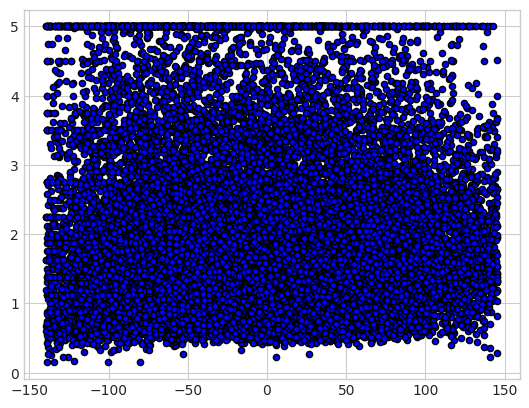

In [112]:
plt.scatter(X_comp, y, c='b', cmap=plt.cm.coolwarm, s=20, edgecolors='k');

In [113]:
model = KNeighborsRegressor()
model.fit(X_comp, y)
predict = model.predict(X_comp)

/tmp/ipykernel_17280/151620241.py:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_comp, y, c='b', cmap=plt.cm.coolwarm, s=20, edgecolors='k');
/tmp/ipykernel_17280/151620241.py:2: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_comp, predict, c='r', cmap=plt.cm.coolwarm, s=20, edgecolors='k');


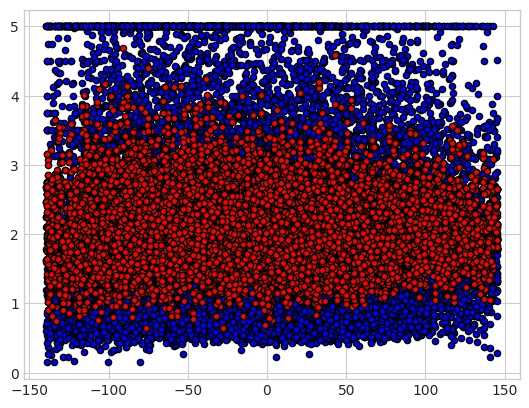

In [114]:
plt.scatter(X_comp, y, c='b', cmap=plt.cm.coolwarm, s=20, edgecolors='k');
plt.scatter(X_comp, predict, c='r', cmap=plt.cm.coolwarm, s=20, edgecolors='k');